# Resting EEG Data

This notebook analyzes a dataset of EEG data collected from healthy young adults.

## Dataset Details

This dataset is a dataset of extra-cranial EEG data recorded in the Voytek Lab. 

Analyzed data is taken from eyes-closed resting state data collected prior to a visual-detection psychophysics task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_10617/1394302548.py:6: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof.utils import trim_spectrum


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB, get_files, load_pickle
from apm.io.data import load_eeg_demo_group_data, load_eeg_demo_info
from apm.analysis import (compute_avgs, unpack_corrs, compute_all_corrs,
                          compute_corrs_to_feature, compute_diffs_to_feature)
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.results import plot_topo
from apm.plts.multi import plot_results_all, plot_topo_row
from apm.plts.utils import make_axes
from apm.plts.settings import EXT, LABELS
from apm.methods import (autocorr_decay_time, dfa, higuchi_fd, lempelziv, lyapunov,
                         sample_entropy, perm_entropy, specparam, irasa)
from apm.methods.settings import (AC_DECAY_PARAMS, DFA_PARAMS, HFD_PARAMS, LZ_PARAMS,
                                  LY_PARAMS, SA_ENT_PARAMS, PE_ENT_PARAMS)
from apm.methods.periodic import alpha_power
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Data Loading

In [4]:
# Define load path
db = APMDB()
LOADPATH = db.data_path / 'eeg1'

In [5]:
# Check the set of results files available for this dataset
get_files(LOADPATH)

['eeg1_group_results.p',
 'eeg1_group_results_peaks.p',
 'eeg1_spatial_corrs.p',
 'eeg1_spatial_corrs_alpha.p',
 'eeg1_spatial_corrs_exp.p']

## Settings

In [6]:
# Define data information
fs = 500
n_seconds = 30

In [7]:
# Define times vector for data
times = create_times(n_seconds + 1/500, fs)

In [8]:
# Add plot kwargs
dot_kwargs = {
    'alpha' : 0.75,
}

In [9]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = db.figs_path / '51_eeg_data'

## Load Data


In [10]:
# Define data path
data_path = Path('/Users/tom/Documents/Research/2-Projects/1a-Current(Voytek)/AperiodicMethods/2-Data/apm_data/')

In [11]:
# Load group data
group_data = load_eeg_demo_group_data(data_path)

In [12]:
# Check data size
n_subjs, n_chs, n_times = group_data.shape
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 29


In [13]:
# Load MNE info object for the current dataset
info = load_eeg_demo_info(data_path)

## Data Checks

In [14]:
# Set example subject index
subj_ind = 13

In [15]:
# Set example channel index
chi = 29

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


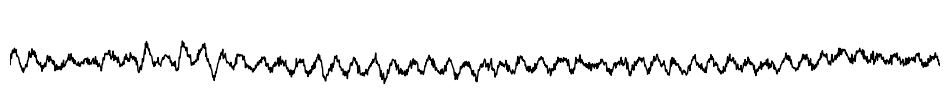

In [16]:
# Plot a segment of time series data
plot_time_series(times, group_data[subj_ind, chi, :], lw=1., xlim=[5, 10], figsize=(12, 1))
plt.gca().axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('eeg_timeseries' + EXT))

In [17]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(group_data[subj_ind, chi, :], fs, nperseg=2*fs, noverlap=fs)

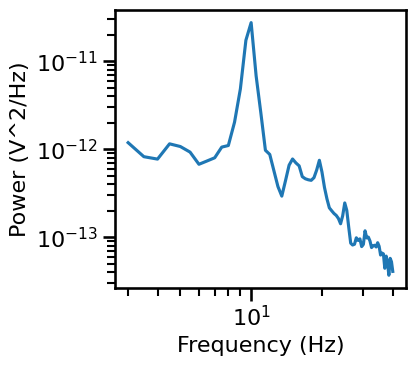

In [18]:
# Plot the power spectrum of the example data segment
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]), figsize=(4.5, 4), 
                   save_fig=SAVE_FIG, file_name='rest_eeg_psd' + EXT, file_path=FIGPATH)

## Load Results

In [19]:
# Load precomputed aperiodic measure results
group_results = load_pickle('eeg1_group_results', LOADPATH)

In [20]:
# Load precomputed peak results
group_results_peaks = load_pickle('eeg1_group_results_peaks', LOADPATH)

In [21]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam', 'irasa']
ts_measures = list(group_results.keys())
[ts_measures.remove(meas) for meas in exp_measures];

#### Check Measures & Labels

In [22]:
LABELS = {
    'autocorr_decay_time' : 'AC Decay',
    'dfa' : 'DFA',
    'higuchi_fd' : 'Higuchi FD',
    'hjorth_complexity' : 'Hjorth',
    'lempelziv' : 'LZC',
    'sample_entropy' : 'SampEnt',
    'perm_entropy' : 'PermEnt',
}

# Collect short labels for time series measures
short_labels = [LABELS[meas] for meas in ts_measures]

In [23]:
# Sub-select results to channel of interest
results = {key : val[:, chi] for key, val in group_results.items()}
results_peaks = {key : val[:, chi] for key, val in group_results_peaks.items()}

In [24]:
# Compute correlations for selected channel
all_corrs = compute_all_corrs(results)

### Compare Exponent Measures

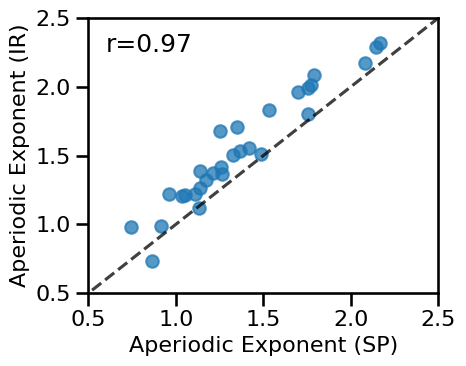

In [25]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs, figsize=(5, 4),
          xlim=[0.5, 2.5], ylim=[0.5, 2.5], tposition='tl', expected=[0, 3],
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (IR)',
          save_fig=SAVE_FIG, file_name='eeg_exp_exp_comp' + EXT, file_path=FIGPATH)

In [26]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.968  CI[+0.898, +0.991],  p=0.000


### Compare Exponent to TS Measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


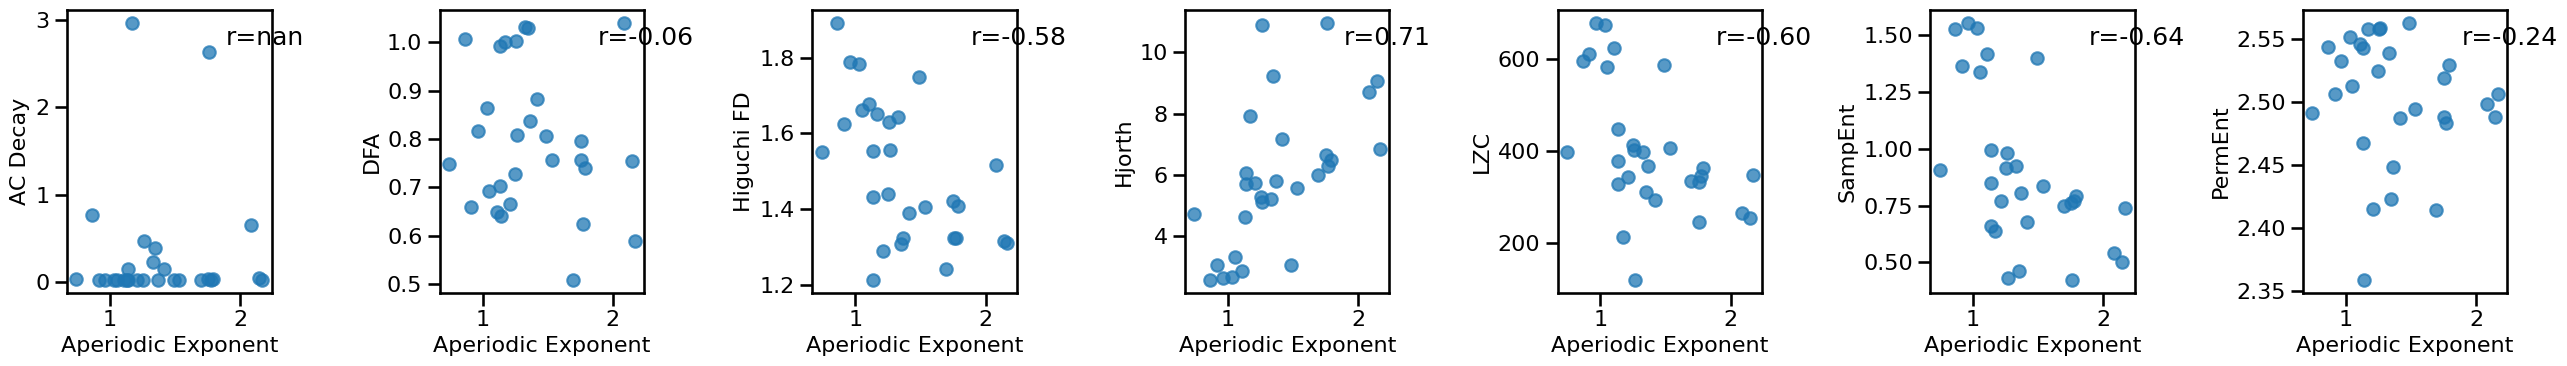

In [27]:
# Plot comparisons between exponent and time series measures
axes = make_axes(1, len(ts_measures), figsize=(26, 4), wspace=0.1)
for ind, meas in enumerate(ts_measures):
    plot_dots(results['specparam'], results[meas], **dot_kwargs,
              xlabel='Aperiodic Exponent', ylabel=LABELS[meas], ax=axes[ind])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_ts_scatters' + EXT))

In [28]:
# Check the correlations between time series and exponent measures
for meas in ts_measures:
    print(meas)
    print('    SP-EXP:  ', format_corr(*all_corrs['specparam'][meas]))
    print('    IR-EXP:  ', format_corr(*all_corrs['irasa'][meas]))

autocorr_decay_time
    SP-EXP:   r=+nan  CI[+nan, +nan],  p=nan
    IR-EXP:   r=+nan  CI[+nan, +nan],  p=nan
dfa
    SP-EXP:   r=-0.063  CI[-0.449, +0.346],  p=0.747
    IR-EXP:   r=-0.098  CI[-0.478, +0.308],  p=0.613
higuchi_fd
    SP-EXP:   r=-0.585  CI[-0.791, -0.253],  p=0.001
    IR-EXP:   r=-0.638  CI[-0.805, -0.386],  p=0.000
hjorth_complexity
    SP-EXP:   r=+0.712  CI[+0.444, +0.865],  p=0.000
    IR-EXP:   r=+0.693  CI[+0.423, +0.846],  p=0.000
lempelziv
    SP-EXP:   r=-0.604  CI[-0.803, -0.291],  p=0.001
    IR-EXP:   r=-0.572  CI[-0.767, -0.230],  p=0.001
sample_entropy
    SP-EXP:   r=-0.641  CI[-0.817, -0.354],  p=0.000
    IR-EXP:   r=-0.636  CI[-0.800, -0.353],  p=0.000
perm_entropy
    SP-EXP:   r=-0.239  CI[-0.497, +0.071],  p=0.211
    IR-EXP:   r=-0.309  CI[-0.553, -0.007],  p=0.102


### Compare Time Series Measures to Each Other

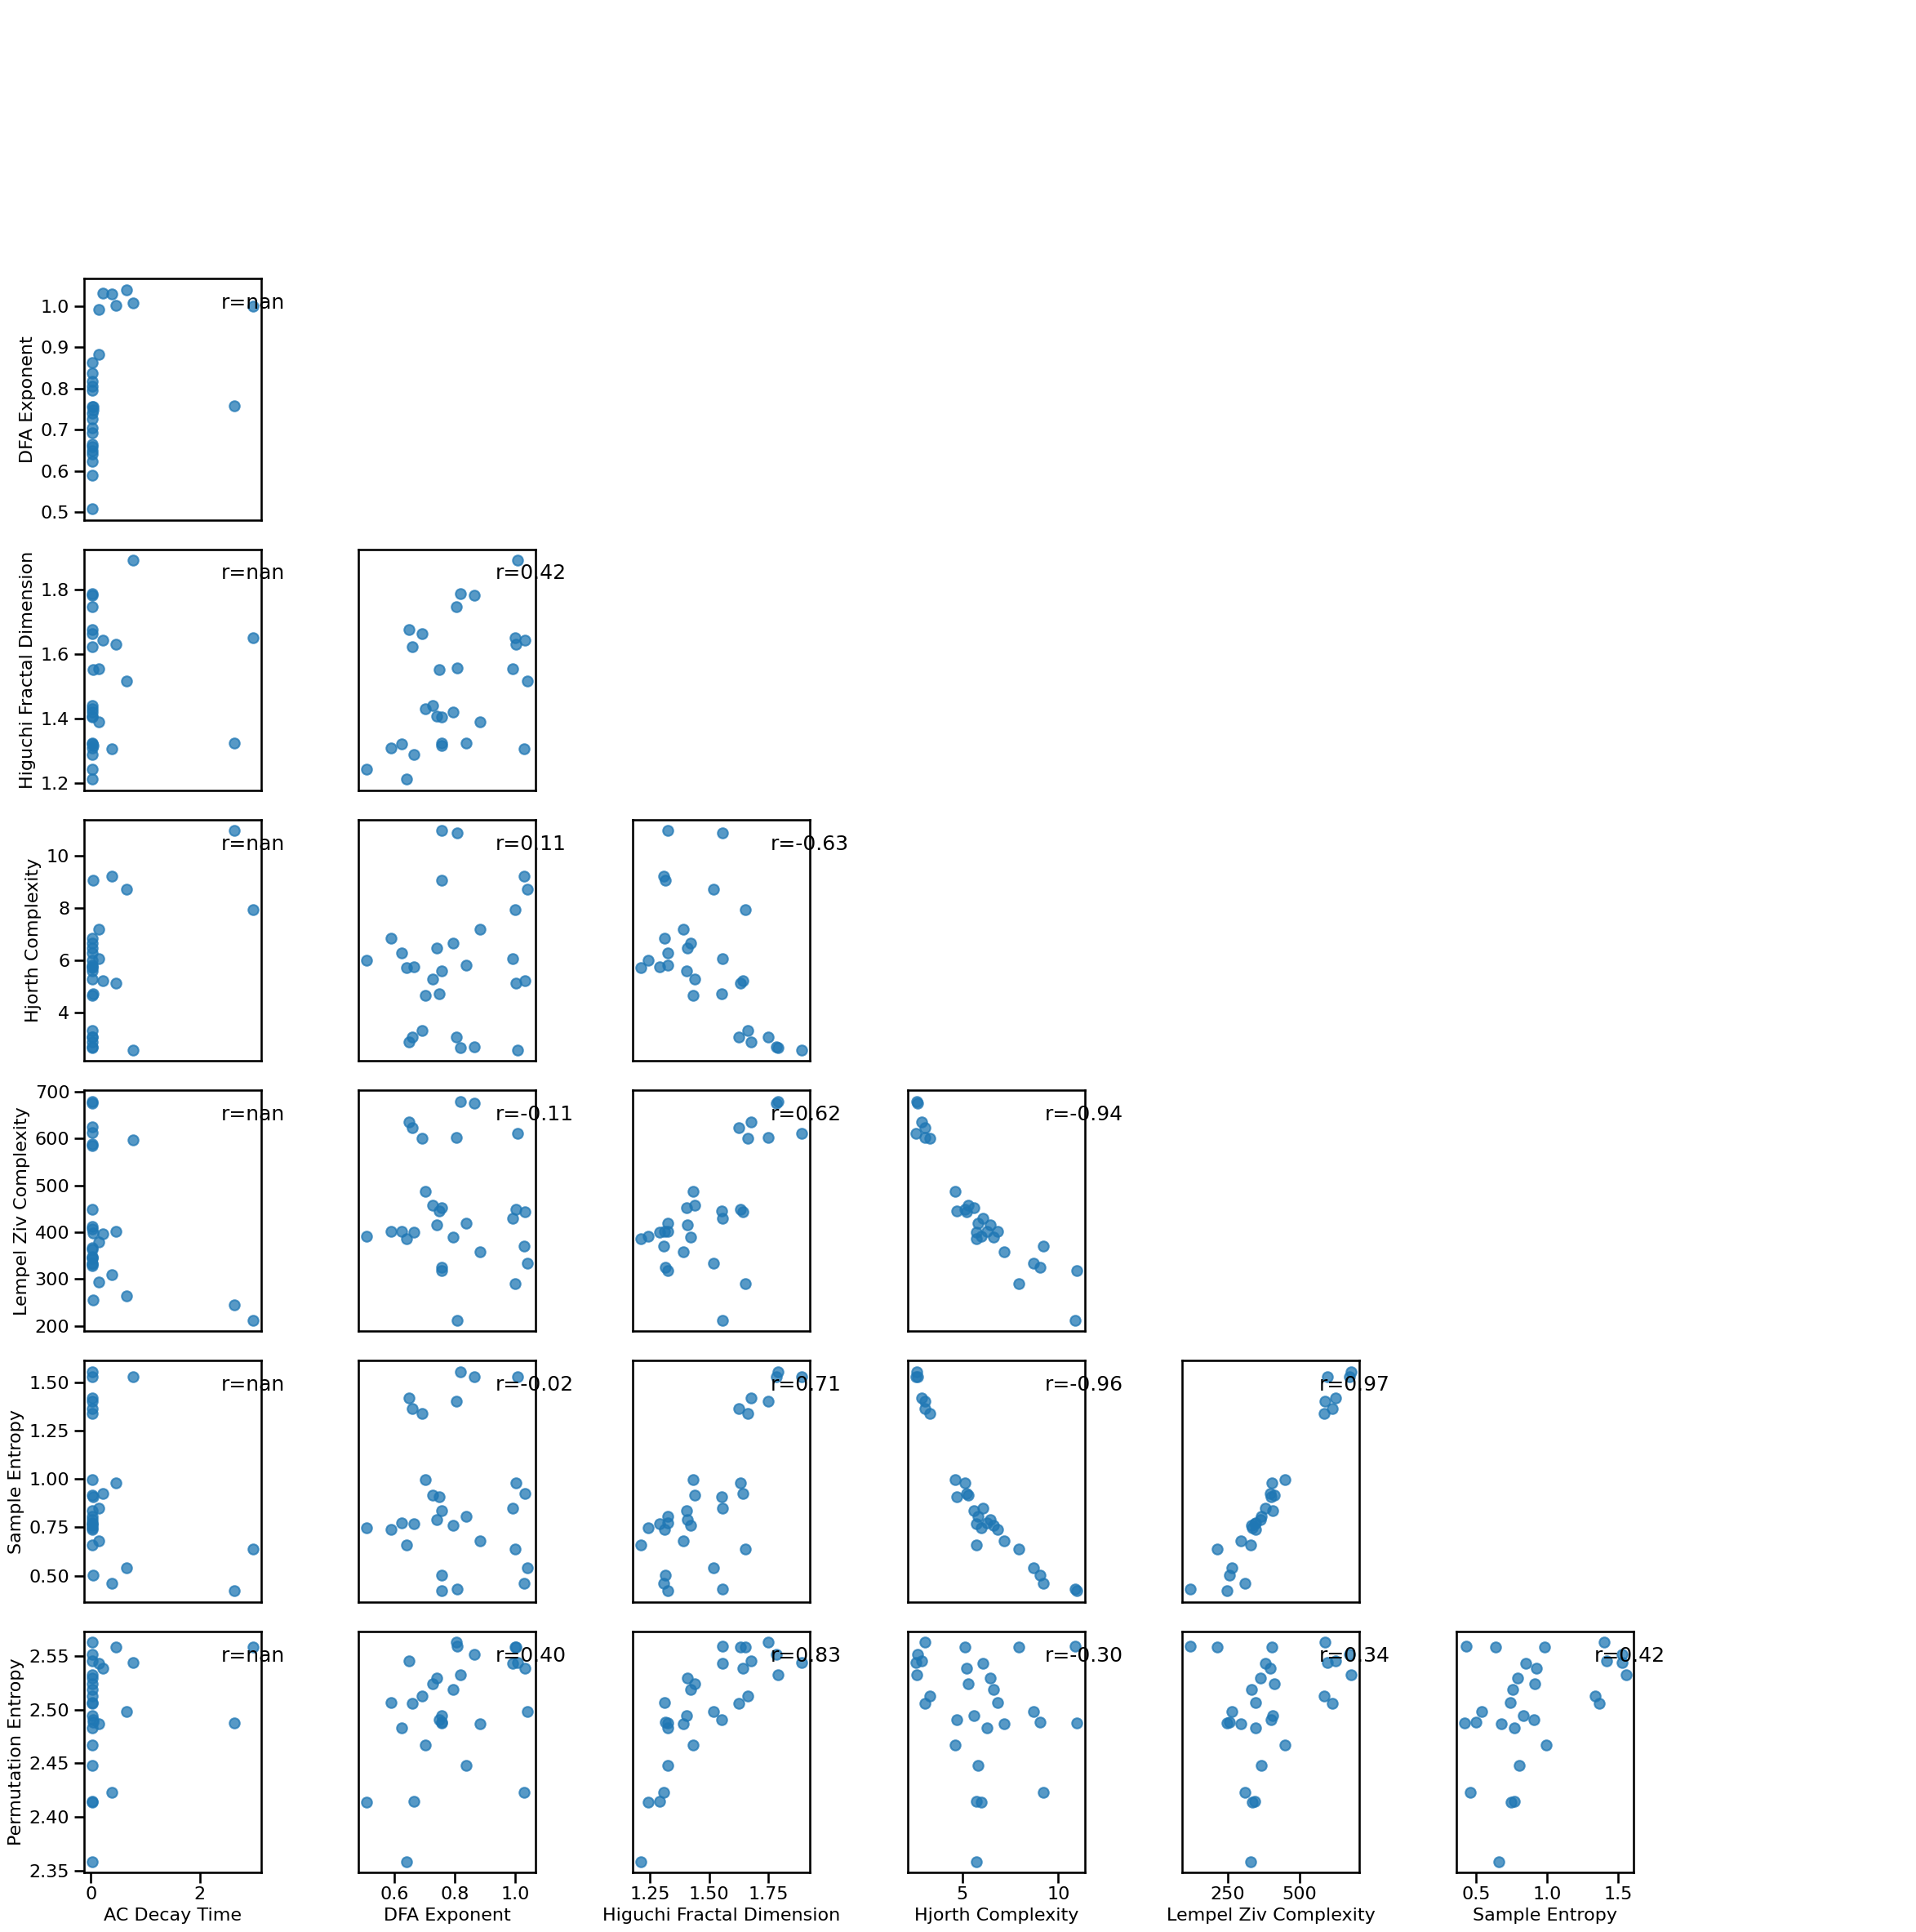

In [29]:
# Plot multi-panel plot comparing all time series measures to each other
plot_results_all(results, ts_measures)

#### Correlations

In [30]:
# Subselect time domain measures
all_corrs_ts = {ke : va for ke, va in all_corrs.items() if ke not in exp_measures}

In [31]:
# Unpack correlations for plotting
all_corrs_mat = unpack_corrs(all_corrs_ts)

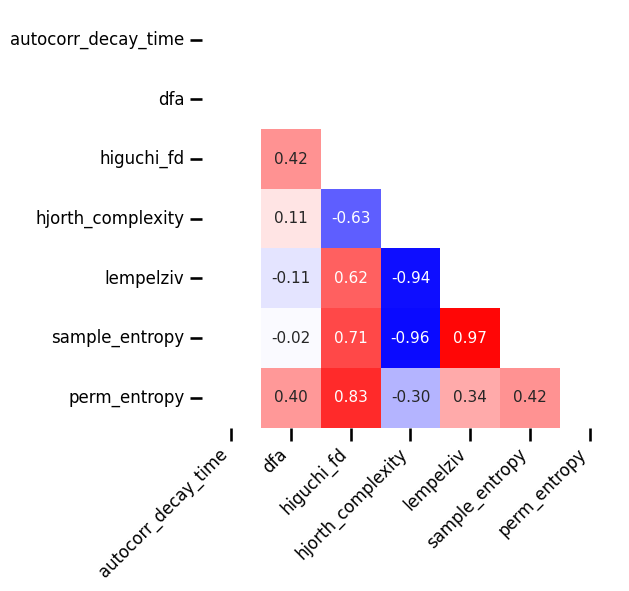

In [32]:
# Plot the correlations matrix across all time series measures
plot_corr_matrix(all_corrs_mat, xticklabels=ts_measures, yticklabels=ts_measures,
                 cbar=False, figsize=(6, 6))
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, fontsize=12, ha='right');
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0, fontsize=12);
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat_subjs' + EXT))

In [33]:
# Extract the correlations between specparam and time domain measures
exp_corrs_subjs = np.atleast_2d([all_corrs['specparam'][label][0] for label in ts_measures]).T

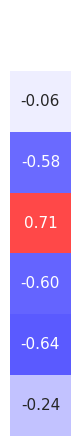

In [34]:
# Plot correlations between exponent and time domain measures
plot_corr_matrix(exp_corrs_subjs, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_subjs' + EXT, file_path=FIGPATH)

### Compare to Alpha Power

In [35]:
# Compute correlations between measures at selected electrode and alpha
alpha_corrs = compute_corrs_to_feature(results, results_peaks['alpha_power'])

In [36]:
# # Compute differences between correlations to alpha
# alpha_corr_diffs = compute_diffs_to_feature(results, results_peaks['alpha_power'])

In [37]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     autocorr_decay_time :   r=+nan  CI[+nan, +nan],  p=nan
     dfa                 :   r=-0.716  CI[-0.866, -0.461],  p=0.000
     higuchi_fd          :   r=-0.657  CI[-0.858, -0.331],  p=0.000
     hjorth_complexity   :   r=+0.261  CI[-0.141, +0.596],  p=0.171
     lempelziv           :   r=-0.265  CI[-0.578, +0.129],  p=0.166
     sample_entropy      :   r=-0.344  CI[-0.653, +0.060],  p=0.068
     perm_entropy        :   r=-0.615  CI[-0.833, -0.293],  p=0.000
     specparam           :   r=+0.281  CI[-0.085, +0.598],  p=0.140
     irasa               :   r=+0.273  CI[-0.082, +0.595],  p=0.151


In [38]:
# Organize correlations between alpha and time domain measures
alpha_corrs_ts = np.atleast_2d([alpha_corrs[label][0] for label in ts_measures]).T

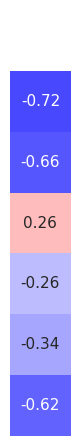

In [39]:
# Plot correlations between alpha and time domain measures
plot_corr_matrix(alpha_corrs_ts, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='alpha_corr_subjs' + EXT, file_path=FIGPATH)

## Spatial Analyses

#### Compute Measures Across Channels

In [40]:
# Compute the average across the group
group_avg = compute_avgs(group_results, np.nanmean)

#### Exponent Topograghies

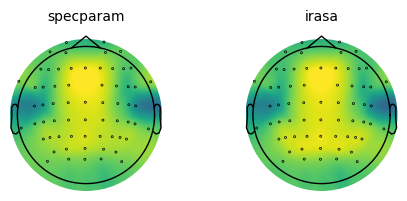

In [41]:
# Plot the group average topographies for the exponent measures
plot_topo_row(group_avg, exp_measures, info,
              save_fig=SAVE_FIG, file_name='exp_topos' + EXT, file_path=FIGPATH)

#### Time Series Measure Topographies

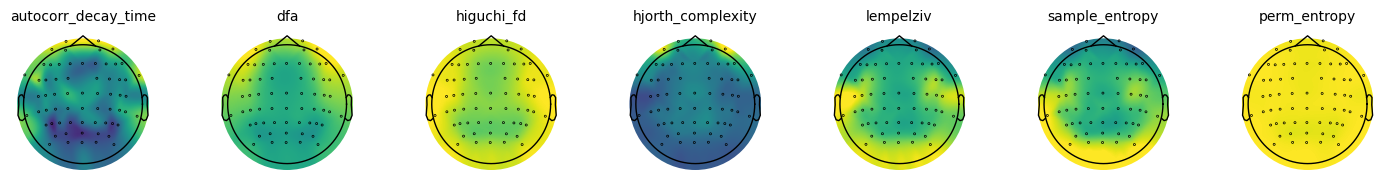

In [42]:
# Plot the group average topographies for the time domain measures
plot_topo_row(group_avg, ts_measures, info)

### Spatial Correlations

In [43]:
# Load precomputed group correlation results
group_corrs = load_pickle('eeg1_spatial_corrs', LOADPATH)

In [44]:
# Unpack correlations for plotting, and compute mask
group_corrs_mat = unpack_corrs(group_corrs)
mask = np.triu(group_corrs_mat)

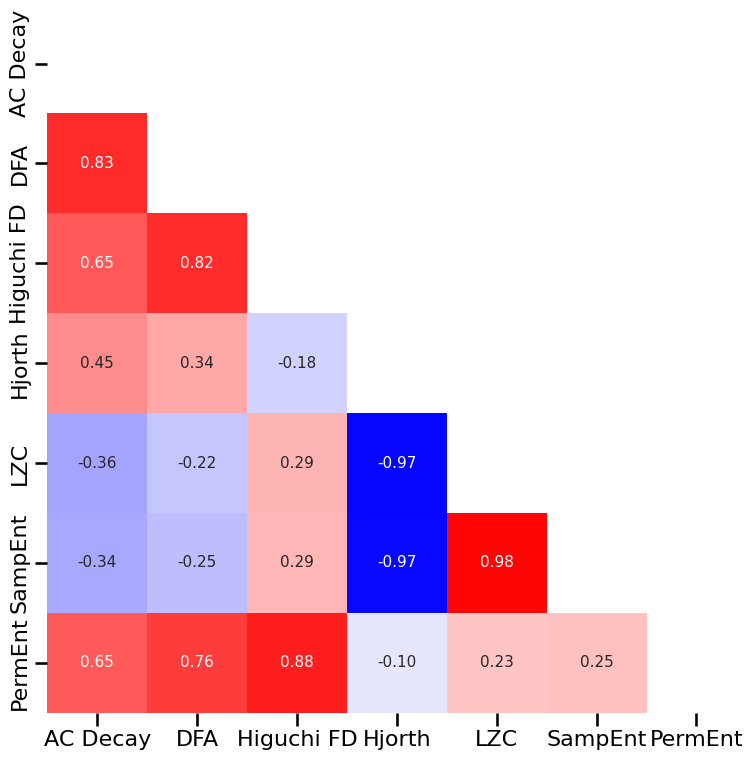

In [45]:
# Plot the correlation matrix spatial topographies
plot_corr_matrix(group_corrs_mat, xticklabels=short_labels, yticklabels=short_labels,
                 cbar=False, figsize=(8, 8),
                 save_fig=SAVE_FIG, file_name='ts_corr_mat' + EXT, file_path=FIGPATH)

In [46]:
# Load precomputed group exponent correlation results
group_exp_corrs = load_pickle('eeg1_spatial_corrs_exp', LOADPATH)

In [47]:
# Organize the correlations between the exponent and time domain measures
exp_corr_mat = np.atleast_2d([group_exp_corrs[label][0] for label in group_exp_corrs]).T

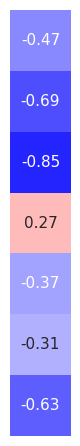

In [48]:
# Plot the correlations between exponent and time domain measures
plot_corr_matrix(exp_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_space' + EXT, file_path=FIGPATH)

## Alpha Power Topography

In [49]:
# Load precomputed group alpha results
group_results_peaks = load_pickle('eeg1_group_results_peaks', LOADPATH)

In [50]:
# Compute the average alpha topography across the group
group_avg_peaks = compute_avgs(group_results_peaks, np.nanmean)

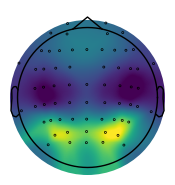

In [51]:
# Plot the average alpha topography across the group
plot_topo(group_avg_peaks['alpha_power'], info, vlim=(-11.5, -10.5),
          save_fig=SAVE_FIG, file_name='alpha_topo' + EXT, file_path=FIGPATH)

In [52]:
# Load precomputed correlations between aperiodic measures and alpha power
group_alpha_corrs = load_pickle('eeg1_spatial_corrs_alpha', LOADPATH)

In [53]:
# Organize the alpha correlations
alpha_corr_mat = np.atleast_2d([group_alpha_corrs[label][0] for label in group_alpha_corrs]).T

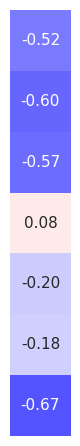

In [54]:
# Plot the correlations between alpha activity and time domain measures
plot_corr_matrix(alpha_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='alpha_corr_space' + EXT, file_path=FIGPATH)

## Conclusions

Conclusions of this empirical data analysis thus far:
- in this EEG data, the specparam & IRASA exponent estimates are highly comparable
- in this empirical data, aperiodic exponent is moderately correlated with the time domain methods

Note that this dataset is analyzed as a small / pilot, such that these interim conclusions are not considered decisive, and are best considered as initial results to be further explored and replicated in subsequent larger datasets.